In [3]:
import pandas as pd
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from collections import defaultdict
import os
import re
import itertools
import networkx as nx
import matplotlib.pyplot as plt
from nltk import ne_chunk, pos_tag
from nltk.tree import Tree

In [4]:
# For the movies, we can keep only the names that talk in the scenario and cretae links between adjacent names. (scene by scene, so that we do not connect characters in different scenes)

# Further idea, get the images of characters from fandom and create a smaller network with the most important ones based on some centrality.

In [5]:
def read_books_from_folder(folder_path):
    # List to hold the content of each book
    books_content = []

    # Loop through each file in the folder
    for filename in os.listdir(folder_path):
        # Construct the full file path
        file_path = os.path.join(folder_path, filename)

        # Check if it's a file and not a directory
        if os.path.isfile(file_path):
            # Read the file and append its content to the list
            with open(file_path, 'r', encoding='utf-8') as file:
                books_content.append(file.read())

    return books_content

In [6]:
# Read the clean books and add their text to a list
folder_path = '/data/Books/'  # Replace with your folder path
books_list = read_books_from_folder(folder_path)

FileNotFoundError: [Errno 2] No such file or directory: '/data/Books/'

In [19]:
# Function to get continuous chunks of named entities
def get_named_entities(text):
#     tokenise the sentence and extract the named entities 
    chunked = ne_chunk(pos_tag(word_tokenize(text)))
    continuous_chunk = []
    current_chunk = []

    for i in chunked:
        if type(i) == Tree:
            current_chunk.append(" ".join([token for token, pos in i.leaves()]))
        elif current_chunk:
            named_entity = " ".join(current_chunk)
            if named_entity not in continuous_chunk:
                continuous_chunk.append(named_entity)
                current_chunk = []
        else:
            continue

    if current_chunk:
        named_entity = " ".join(current_chunk)
        if named_entity not in continuous_chunk:
            continuous_chunk.append(named_entity)

    return continuous_chunk

In [20]:
# Function to create a mapping from partial to full names
def create_name_mapping(character_df):
    name_mapping = {}  
    
    for i in range(len(character_df)):
        
        name = character_df.loc[i, "name"]
        
        if pd.isnull(character_df.loc[i, "first_name"]) and pd.isnull(character_df.loc[i, "last_name"]):
            name_mapping[name] = name
        elif pd.isnull(character_df.loc[i, "last_name"]) and not pd.isnull(character_df.loc[i, "first_name"]):
            if character_df.loc[i, "first_name"] not in name_mapping:
                name_mapping[character_df.loc[i, "first_name"]] = [name]
            else: 
                name_mapping[character_df.loc[i, "first_name"]].append(name)
        elif pd.isnull(character_df.loc[i, "first_name"]) and not pd.isnull(character_df.loc[i, "last_name"]):
            # there is no character with only last name but let's handle this here
            name_mapping[character_df.loc[i, "last_name"]] = name
        else:
            name_mapping[name] = name
            if character_df.loc[i, "first_name"] not in name_mapping:
                name_mapping[character_df.loc[i, "first_name"]] = [name]
            else: 
                name_mapping[character_df.loc[i, "first_name"]].append(name)
            if character_df.loc[i, "last_name"] not in name_mapping:
                name_mapping[character_df.loc[i, "last_name"]] = [name]
            else:
                name_mapping[character_df.loc[i, "last_name"]].append(name)

    return name_mapping

In [21]:
def check_entities(entities):
    prefixes = ('Professor ', 'Madam ', 'Aunt ', 'Uncle ', 'Miss ', 'Mr. ', 'Mrs. ')
    new_entities = []

    for entity in entities:
        if entity.startswith(prefixes):
            # Remove the prefix from the entity
            for prefix in prefixes:
                if entity.startswith(prefix):
                    entity = entity[len(prefix):]
                    break
        new_entities.append(entity)
        
    return new_entities    

In [22]:
def find_entities(book_text, character_df):
    # Create a mapping from partial names to full names
    name_mapping = create_name_mapping(character_df)

    # Tokenize the book text into sentences
    sentences = nltk.sent_tokenize(book_text)

    # Initialize a dictionary to track the most recent mention of each character
    recent_mentions = {}

    # Find entities in each sentence and map partial names to full names
    sent_entity_list = []
    for sent in sentences:
        entities_old = get_named_entities(sent)
        entities = check_entities(entities_old) 
        names = []
        for entity in entities:
            if entity in name_mapping:
                
                # if entity is a partial name
                if isinstance(name_mapping[entity], list):
                    # If the character has been mentioned before
                    if entity in recent_mentions:
                        recent_character = recent_mentions[entity]
                    else:
                        # If the entity hasn't been mentioned, return the first character in the list for that last name
                        recent_character = name_mapping[entity][0]
                        # If entity is a last name insert character in recent mentions
                        if entity in character_df['last_name'].tolist():
                            recent_mentions[entity] = recent_character
                        # If entity is a first name, find last name and add it to recent mentions
                        else:
                            last_name = characters_df.loc[characters_df['first_name'] == entity, 'last_name'].values[0]
                            if type(last_name) != float: recent_mentions[last_name] = recent_character
 
                    names.append(recent_character)
    
                # if entity is a fullname
                else:                    
                    # Update the recent mention for the character by their last name
                    last_name = characters_df.loc[characters_df['name'] == entity, 'last_name'].values[0]
                    recent_mentions[last_name] = name_mapping[entity]
                    
                    names.append(name_mapping[entity])

        sent_entity_list.append({'sentence': sent, 'ents_old': entities_old, 'ents': entities, 'entity': names})

    # Create a dataframe from the list of sentencies-entities
    sent_entity_df = pd.DataFrame(sent_entity_list)

    return sent_entity_df

In [23]:
def find_relationships(sent_entity_df):
    # Define a window size to look for relationships within
    window_size = 3 # int(sent_entity_df.index.to_series().diff().mean())
    # print(window_size)
    # Initialize a list to hold relationships
    relationships = []

    # Loop through the sentences to find relationships within the window size
    for i in range(0, len(sent_entity_df) - window_size):
        window = sent_entity_df.iloc[i:i + window_size]
        all_entities = list(set(itertools.chain.from_iterable(window['entity'])))
        window_sentences = " ".join(window['sentence'])  # Combine sentences in the window
        for a, b in itertools.combinations(all_entities, 2):
            relationships.append({'source': min(a, b), 'target': max(a, b), 'sentence': window_sentences})

    # Create a DataFrame from the relationships
    relationships_df = pd.DataFrame(relationships)

    # Remove duplicate relationships
    relationships_df = relationships_df.drop_duplicates(subset=['source', 'target']).reset_index(drop=True) # ???????
    
    return relationships_df

In [24]:
def build_network(relationships_df):
    # If you wish to visualize the graph, continue with this part
    # Create a networkx graph from the relationships DataFrame
    G = nx.Graph()

    # Add edges from relationships_df to the graph
    for index, row in relationships_df.iterrows():
        G.add_edge(row['source'], row['target'])
    
    # Print number of nodes and edges
    print(G)

    # Use a circular layout for the nodes
    d = dict(G.degree)
    # pos = nx.kamada_kawai_layout(G)

    # Draw the network
    plt.figure(figsize=(12, 12))
    # nx.draw_networkx(G, pos, with_labels=False)
    nx.draw_kamada_kawai(G, node_size=[v * 3 for v in d.values()],node_color = "Yellow", edge_color="grey", width=0.2, alpha=0.5)
    labels = nx.draw_networkx_labels(G, pos=nx.kamada_kawai_layout(G), font_size=7)
    # Display the plot
    plt.show()
    
    return G

In [25]:
def most_degree(G):
    # Calculate degree of each node
    degrees = dict(G.degree())

    # Sort nodes by degree in descending order
    sorted_degrees = sorted(degrees.items(), key=lambda item: item[1], reverse=True)

    # Print the first 20 nodes with the highest degree
    print("Top 20 nodes by degree: \n")
    for node, degree in sorted_degrees[:20]:
        print(f"{node}: {degree}")

In [26]:
# Read the characters list that we scrapped from fandom
characters_df = pd.read_csv('characters_fandom.csv')

Graph with 104 nodes and 632 edges


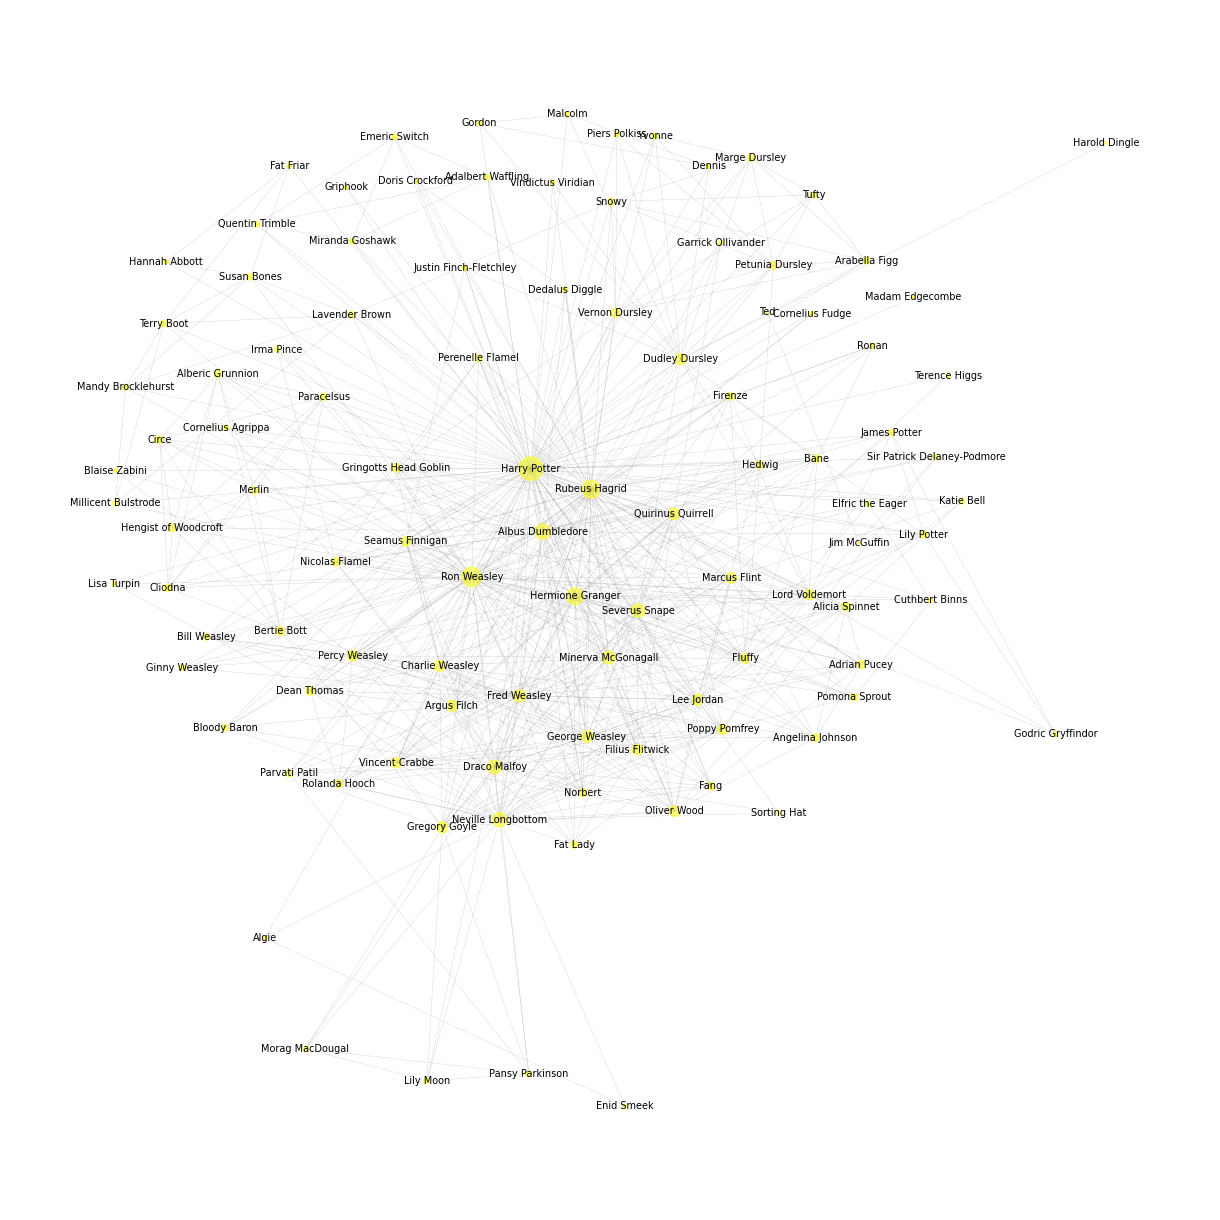

Top 20 nodes by degree: 

Harry Potter: 94
Ron Weasley: 64
Rubeus Hagrid: 55
Hermione Granger: 47
Albus Dumbledore: 39
Neville Longbottom: 35
Draco Malfoy: 32
Severus Snape: 30
Minerva McGonagall: 28
Fred Weasley: 25
George Weasley: 23
Quirinus Quirrell: 22
Dudley Dursley: 21
Lee Jordan: 21
Charlie Weasley: 21
Gregory Goyle: 21
Argus Filch: 21
Percy Weasley: 19
Filius Flitwick: 19
Oliver Wood: 19


In [28]:
sent_entity_df1 = find_entities(books_list[0], characters_df)
relationships_df1 = find_relationships(sent_entity_df1)
G1 = build_network(relationships_df1)
most_degree(G1)

In [29]:
relationships_df1

source              target  \
0      Dudley Dursley      Vernon Dursley   
1      Dudley Dursley         Lily Potter   
2      Dudley Dursley        Harry Potter   
3      Dudley Dursley       Harold Dingle   
4        Jim McGuffin                 Ted   
..                ...                 ...   
627       Bertie Bott  Neville Longbottom   
628     Ginny Weasley    Hermione Granger   
629     Ginny Weasley         Ron Weasley   
630       Ron Weasley      Vernon Dursley   
631  Hermione Granger      Vernon Dursley   

                                              sentence  
0    He was a big, beefy \nman with hardly any neck...  
1    The Dursleys had everything they wanted, but t...  
2    This bunch were whispering \nexcitedly, too, a...  
3    It \nmight have been Harvey. Or Harold. There ...  
4    “Most mysterious. And now, over to Jim \nMcGuf...  
..                                                 ...  
627  They had hoped that Goyle, who was almost as \...  
628  “Not where I’m going, I promise you,” said Har...  
629  “Not where I’m going, I promise you,” said Har...  
630  “In a manner of speaking,” said Uncle Vernon. ...  
631  “In a manner of speaking,” said Uncle Vernon. ...  

[632 rows x 3 columns]

Graph with 86 nodes and 620 edges


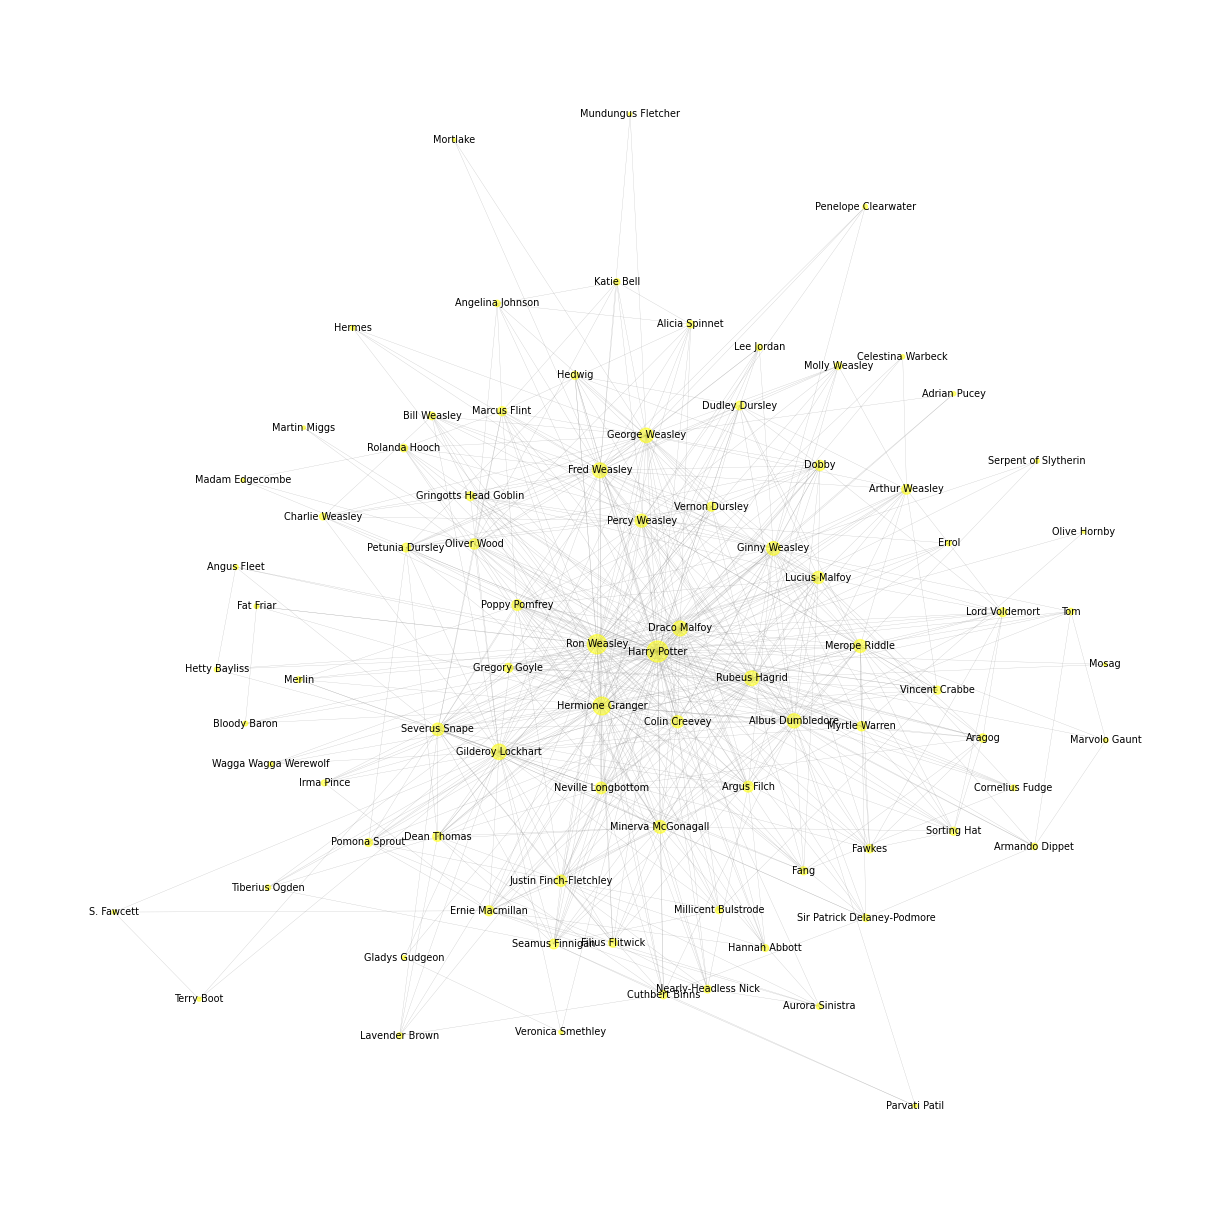

Top 20 nodes by degree: 

Harry Potter: 76
Ron Weasley: 64
Hermione Granger: 55
Gilderoy Lockhart: 41
Draco Malfoy: 38
Fred Weasley: 38
Rubeus Hagrid: 37
George Weasley: 36
Albus Dumbledore: 35
Ginny Weasley: 32
Percy Weasley: 29
Merope Riddle: 29
Minerva McGonagall: 28
Severus Snape: 27
Lucius Malfoy: 25
Colin Creevey: 25
Neville Longbottom: 23
Justin Finch-Fletchley: 22
Argus Filch: 20
Poppy Pomfrey: 20


In [31]:
sent_entity_df2 = find_entities(books_list[1], characters_df)
relationships_df2 = find_relationships(sent_entity_df2)
G2 = build_network(relationships_df2)
most_degree(G2)

Graph with 91 nodes and 700 edges


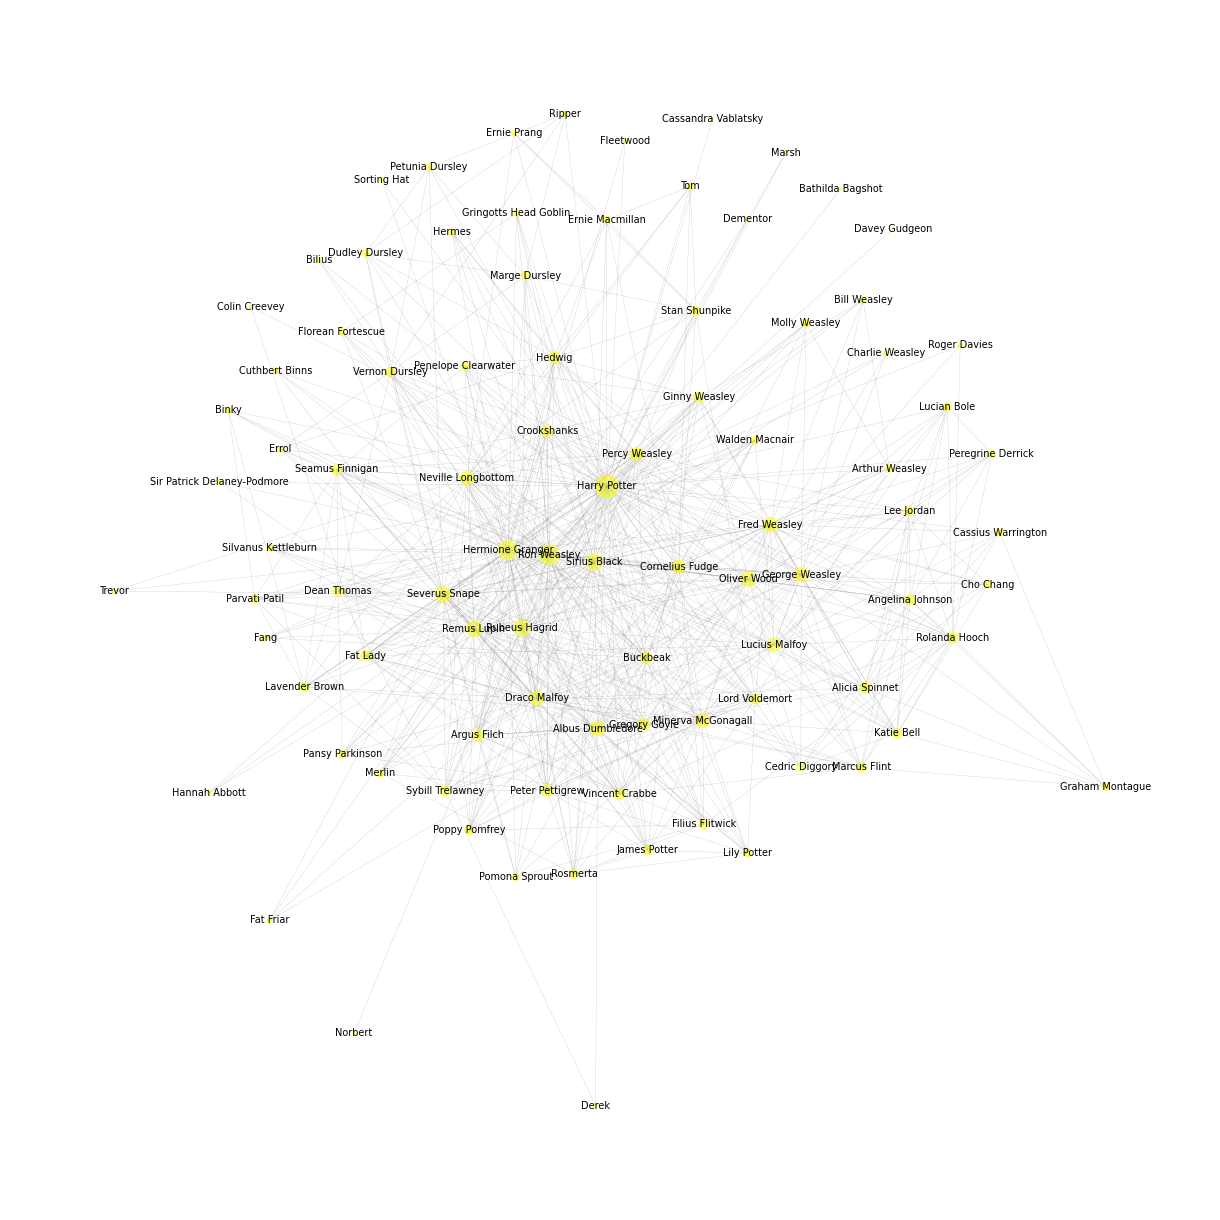

Top 20 nodes by degree: 

Harry Potter: 84
Ron Weasley: 63
Hermione Granger: 58
Severus Snape: 41
Rubeus Hagrid: 41
Sirius Black: 41
Remus Lupin: 39
Fred Weasley: 34
Albus Dumbledore: 34
George Weasley: 33
Oliver Wood: 33
Minerva McGonagall: 31
Draco Malfoy: 31
Neville Longbottom: 30
Percy Weasley: 28
Cornelius Fudge: 28
Lucius Malfoy: 28
Peter Pettigrew: 23
Hedwig: 22
Gregory Goyle: 22


In [32]:
sent_entity_df3 = find_entities(books_list[2], characters_df)
relationships_df3 = find_relationships(sent_entity_df3)
G3 = build_network(relationships_df3)
most_degree(G3)

Graph with 171 nodes and 1357 edges


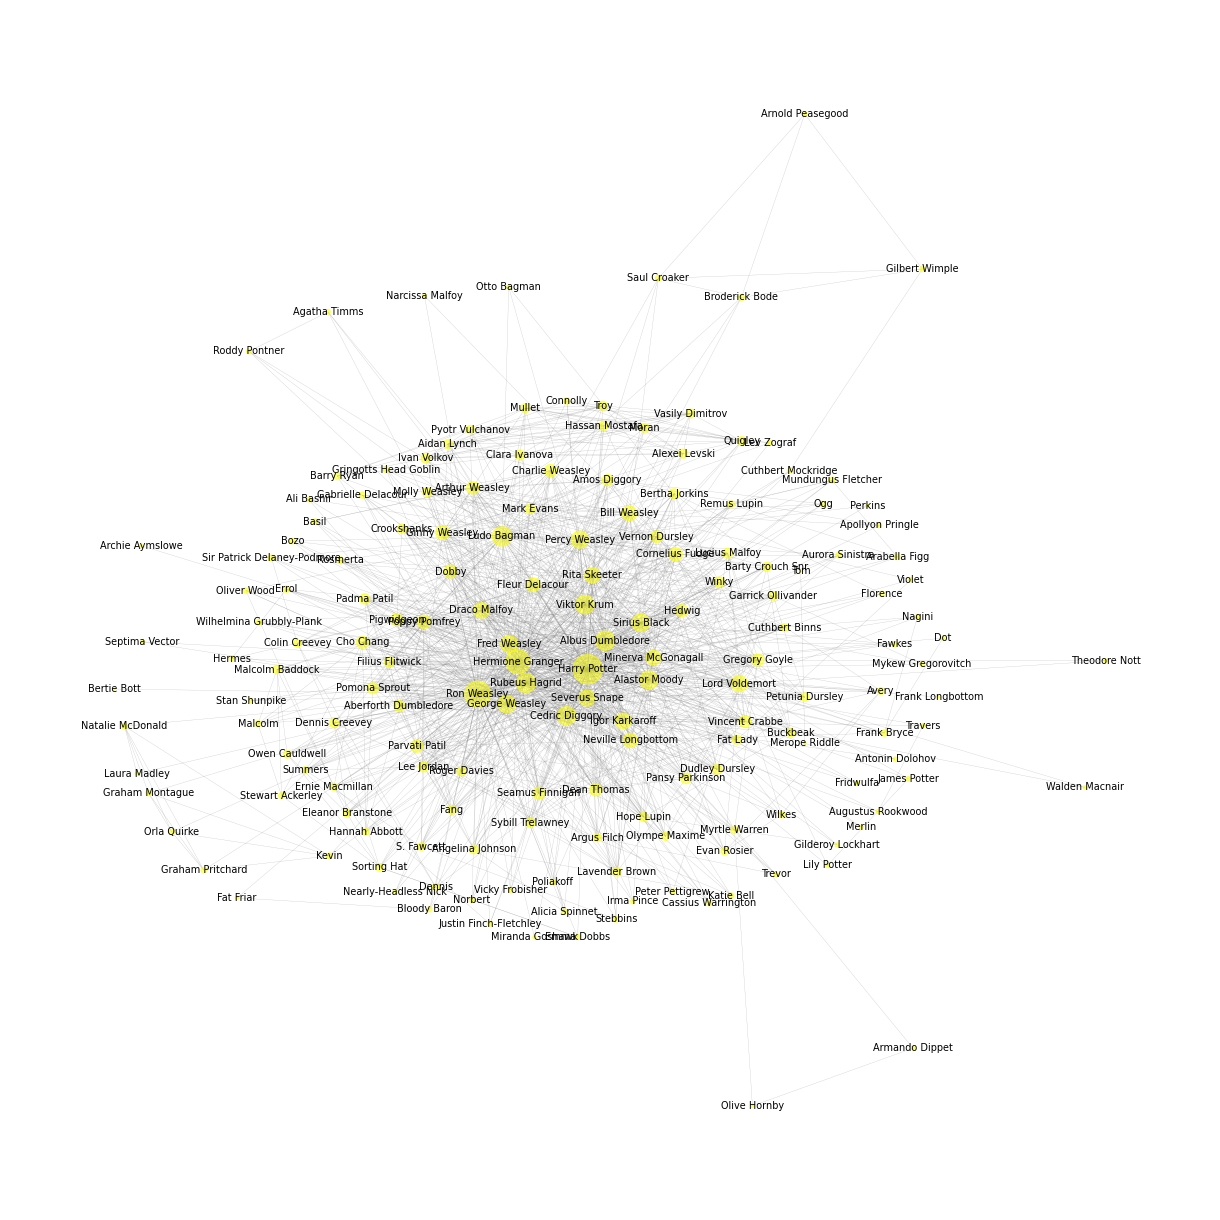

Top 20 nodes by degree: 

Harry Potter: 147
Ron Weasley: 115
Hermione Granger: 98
Ludo Bagman: 64
Albus Dumbledore: 63
Rubeus Hagrid: 63
Viktor Krum: 58
Cedric Diggory: 57
Alastor Moody: 55
Sirius Black: 53
George Weasley: 52
Percy Weasley: 50
Fred Weasley: 49
Lord Voldemort: 44
Severus Snape: 44
Igor Karkaroff: 42
Draco Malfoy: 41
Rita Skeeter: 40
Bill Weasley: 37
Minerva McGonagall: 37


In [33]:
sent_entity_df4 = find_entities(books_list[3], characters_df)
relationships_df4 = find_relationships(sent_entity_df4)
G4 = build_network(relationships_df4)
most_degree(G4)

Graph with 211 nodes and 2113 edges


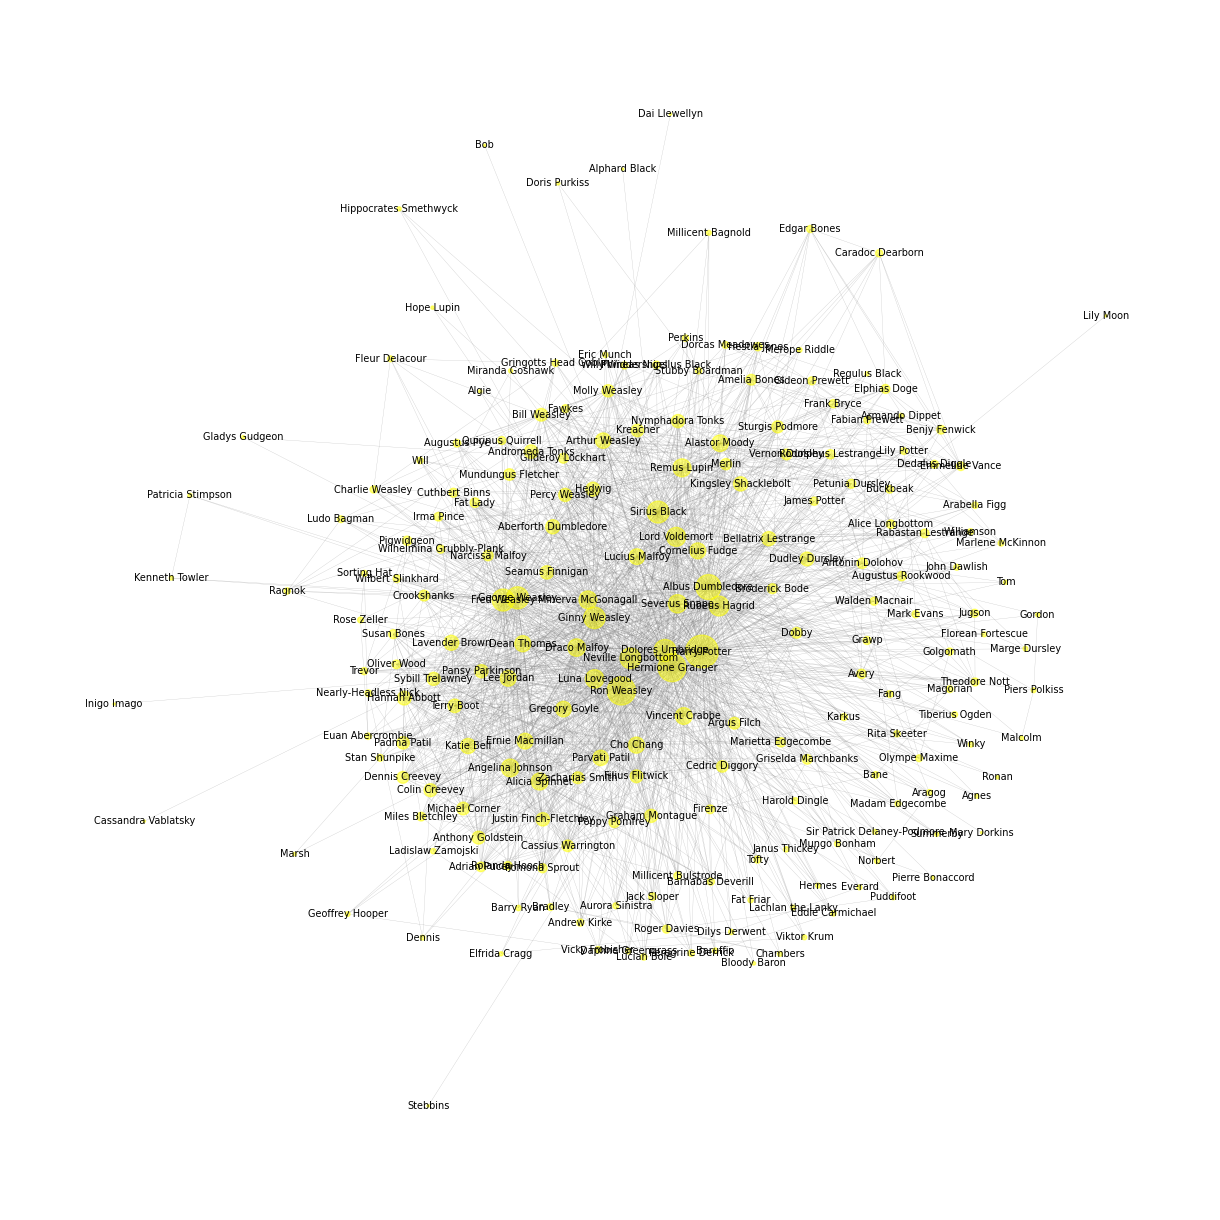

Top 20 nodes by degree: 

Harry Potter: 186
Ron Weasley: 138
Hermione Granger: 136
Albus Dumbledore: 108
George Weasley: 85
Fred Weasley: 84
Sirius Black: 83
Dolores Umbridge: 83
Ginny Weasley: 80
Neville Longbottom: 74
Rubeus Hagrid: 68
Lord Voldemort: 63
Luna Lovegood: 59
Severus Snape: 58
Remus Lupin: 56
Minerva McGonagall: 55
Angelina Johnson: 55
Draco Malfoy: 53
Alicia Spinnet: 50
Vincent Crabbe: 49


In [34]:
sent_entity_df5 = find_entities(books_list[4], characters_df)
relationships_df5 = find_relationships(sent_entity_df5)
G5 = build_network(relationships_df5)
most_degree(G5)

Graph with 187 nodes and 1447 edges


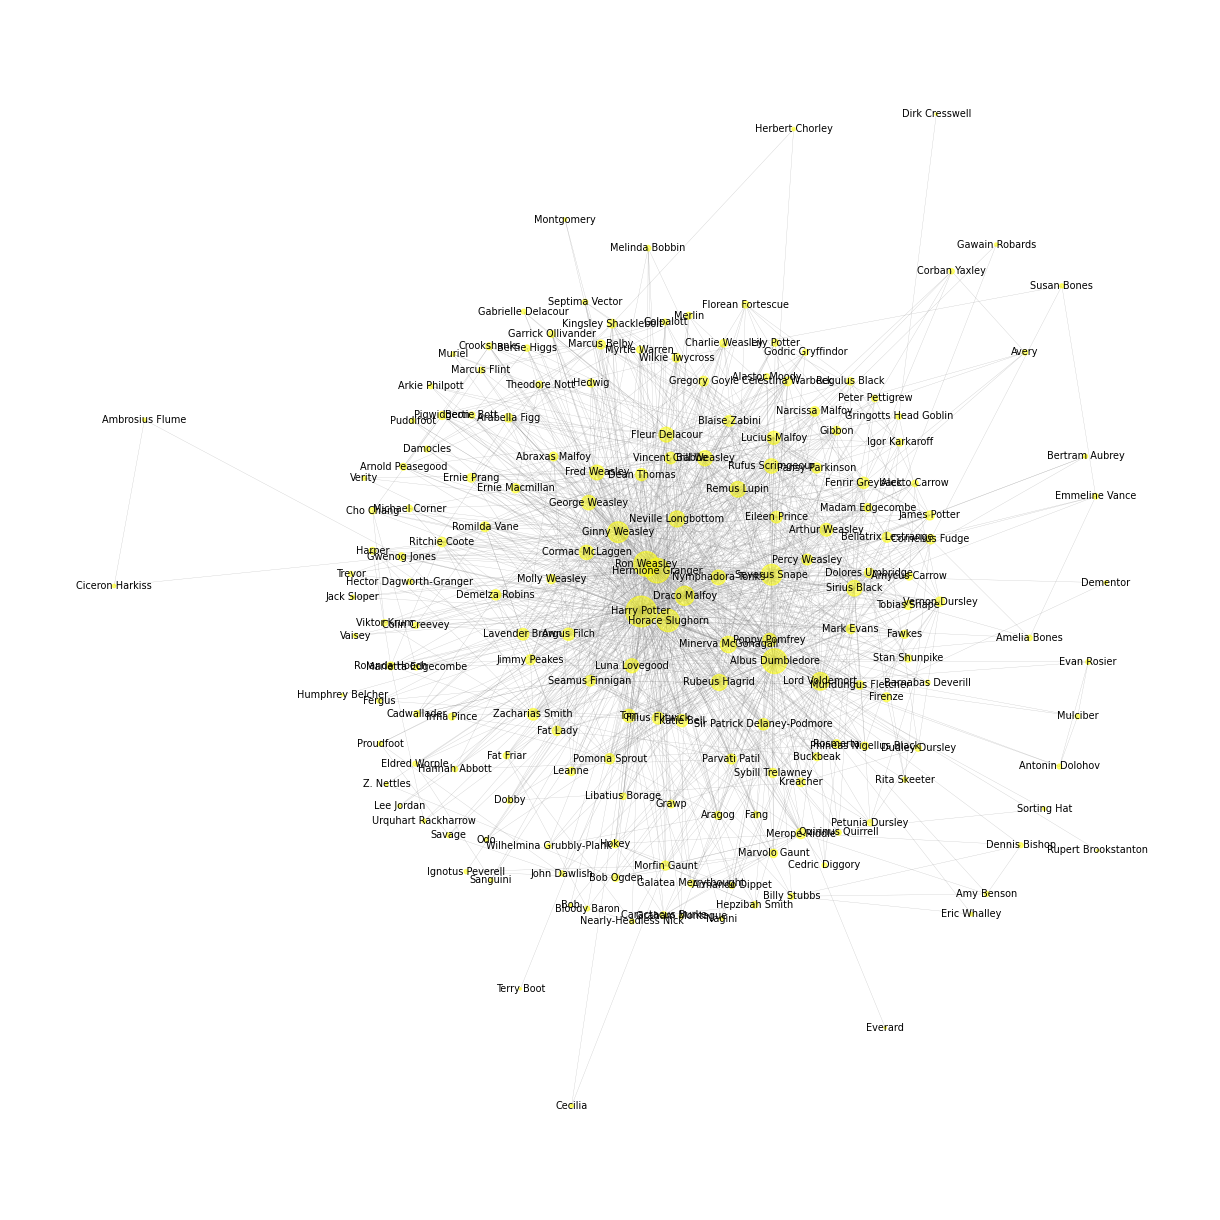

Top 20 nodes by degree: 

Harry Potter: 161
Albus Dumbledore: 106
Ron Weasley: 106
Hermione Granger: 104
Horace Slughorn: 86
Severus Snape: 74
Ginny Weasley: 74
Draco Malfoy: 63
Lord Voldemort: 54
Minerva McGonagall: 46
Neville Longbottom: 44
Rubeus Hagrid: 44
Sirius Black: 42
Remus Lupin: 42
Bill Weasley: 40
Fleur Delacour: 38
Nymphadora Tonks: 37
Fred Weasley: 37
Rufus Scrimgeour: 36
George Weasley: 36


In [36]:
sent_entity_df6 = find_entities(books_list[5], characters_df)
relationships_df6 = find_relationships(sent_entity_df6)
G6 = build_network(relationships_df6)
most_degree(G6)

Graph with 187 nodes and 1707 edges


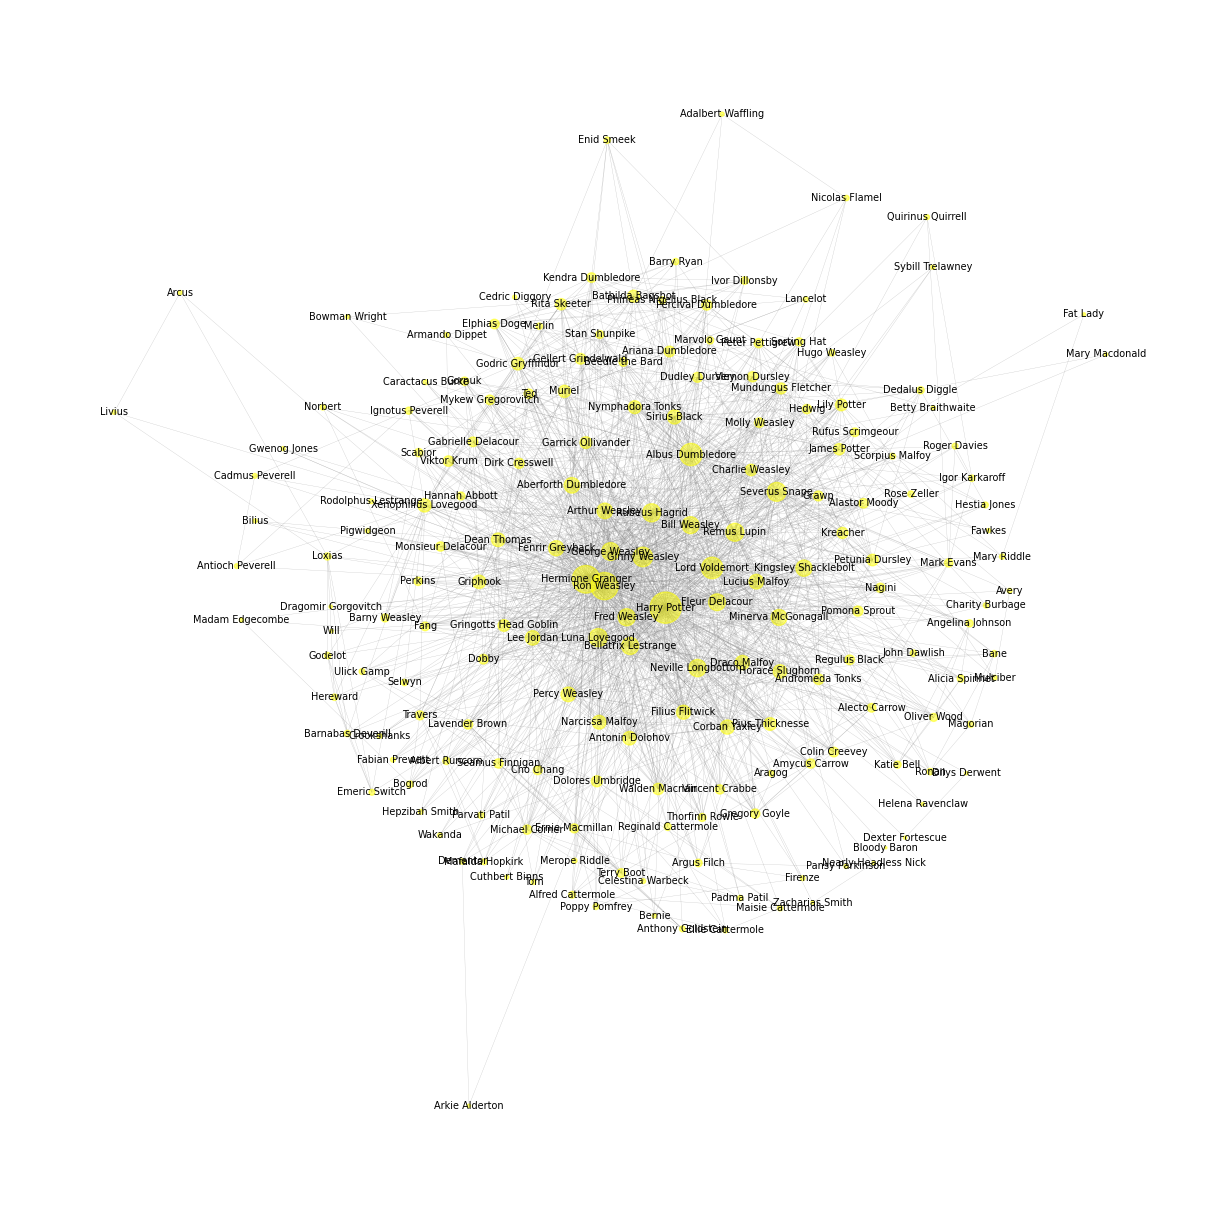

Top 20 nodes by degree: 

Harry Potter: 169
Hermione Granger: 132
Ron Weasley: 129
Albus Dumbledore: 86
Lord Voldemort: 80
Ginny Weasley: 66
Severus Snape: 62
Rubeus Hagrid: 57
Luna Lovegood: 57
Remus Lupin: 56
George Weasley: 55
Neville Longbottom: 52
Bellatrix Lestrange: 51
Fred Weasley: 51
Bill Weasley: 50
Fleur Delacour: 49
Kingsley Shacklebolt: 46
Minerva McGonagall: 44
Aberforth Dumbledore: 42
Arthur Weasley: 42


In [37]:
sent_entity_df7 = find_entities(books_list[6], characters_df)
relationships_df7 = find_relationships(sent_entity_df7)
G7 = build_network(relationships_df7)
most_degree(G7)